# Pipeline

In [ ]:
#Instalaciones
import nltk

import tabulate
import pandas as pd
import plotly.express as px
from nltk.corpus import stopwords

import re
from typing_extensions import *
from typing import *

import numpy as np
import pandas as pd
import re
import plotly.express as px


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
nltk.download('stopwords')
nltk.download('wordnet')

import string

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 1. Lectura de datos

In [ ]:
GITHUB_URL: Final[str] = 'https://raw.githubusercontent.com/LoganTaurus/DB-Project-01/main/'

## Carga de datos de Entrenamiento

In [ ]:
# Leer el archivo XLSX
df = pd.read_excel(GITHUB_URL + 'ODScat-345.xlsx')

# Si hay problemas de codificación, puedes intentar corregirlos
df = df.applymap(lambda x: x.encode('latin1', errors='ignore').decode('utf-8', errors='ignore') if isinstance(x, str) else x)

# Guardar el archivo corregido
df.to_excel('archivo_corregido.xlsx', index=False)

<ipython-input-22-fafc6660baa3>:5: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



## Carga de datos a predecir

In [ ]:
# Leer el archivo XLSX
df_predecir = pd.read_excel(GITHUB_URL + 'TestODScat-345.xlsx')

# Si hay problemas de codificación, puedes intentar corregirlos
df_predecir = df_predecir.applymap(lambda x: x.encode('latin1', errors='ignore').decode('utf-8', errors='ignore') if isinstance(x, str) else x)

# Guardar el archivo corregido
df_predecir.to_excel('archivo_corregido_no_etiquetados.xlsx', index=False)

# 2. Construcción del pipeline

In [ ]:
# Clase personalizada para la limpieza de datos
class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stopwords = set(stopwords.words('spanish'))
        fillerWord =  ("Eh","Mmm","Pues","Bueno","Este","Como","Entonces","O sea","Tipo","¿Sabes?","En fin","¿Entiendes?","Vale","La cosa es que", "¿Verdad?")
        self.fillerword_reg= r"\b(Eh|Mmm|Pues|Bueno|Este|Como|Entonces|O\s+sea|Tipo|¿Sabes?|En\s+fin|¿Entiendes?|Vale|La\s+cosa\s+es\s+que|¿Verdad?)\b"
        remove = ["no", "ni", "tampoco", "jamás", "nunca", "nadie", "ninguno", "ningún", "nada"]
        for word in remove:
            self.stopwords.discard(word)
        self.stopwords.add(fillerWord)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        cleaned_data = []
        for text in X:
            rev = re.sub("#", "", text)
            rev = re.sub(r'^https?:\/\/.*[\r\n]*', '', rev, flags=re.MULTILINE)
            html = re.compile(r'<.*?>')
            rev = html.sub(r"", rev)
            rev = re.sub(r'@\w+', "", rev)
            rev = re.sub(r'#\w+', "", rev)
            rev = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', rev)
            rev = re.sub('[^A-Za-z\s]+', "", rev)
            rev = rev.lower()
            rev = rev.split()
            rev = [self.lemmatizer.lemmatize(word) for word in rev if word not in self.stopwords]
            rev = ' '.join(rev)
            filler = re.compile(self.fillerword_reg)
            rev = filler.sub("", rev)
            cleaned_data.append(rev)
        return cleaned_data


# Codificación de etiquetas
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)

# Pipeline
pipeline = Pipeline([
    ('cleaning', CustomPreprocessor()),  # Limpieza de los textos
    ('vectorizer', TfidfVectorizer(max_features=3000, min_df=3, max_df=0.6)),  # Vectorización con Tfidf
    ('model', MultinomialNB())  # Modelo Multinomial Naive Bayes
])

# División de los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=15)

# Ajustar el pipeline
pipeline.fit(X_train, y_train)

# Predicción y evaluación
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# 3. Testear el funcionamineto del pipeline

In [ ]:
def data_cleaning(data):
    cleaned_data = []
    fillerWord =  ("Eh","Mmm","Pues","Bueno","Este","Como","Entonces","O sea","Tipo","¿Sabes?","En fin","¿Entiendes?","Vale","La cosa es que", "¿Verdad?")
    fillerword_reg= r"\b(Eh|Mmm|Pues|Bueno|Este|Como|Entonces|O\s+sea|Tipo|¿Sabes?|En\s+fin|¿Entiendes?|Vale|La\s+cosa\s+es\s+que|¿Verdad?)\b"
    STOPWORDS = set(stopwords.words('spanish'))
    remove = ["no", "ni", "tampoco", "jamás", "nunca", "nadie", "ninguno", "ningún", "nada"]
    for i in remove:
        STOPWORDS.discard(i)

    STOPWORDS.add(fillerWord)
    for i in range(len(data)):
        rev = re.sub("#", "", data[i])
        rev = re.sub(r'^https?:\/\/.*[\r\n]*', '',rev, flags=re.MULTILINE)
        html=re.compile(r'<.*?>')
        rev =html.sub(r"", rev)
        rev=re.sub(r'@\w+',"",rev)
        rev=re.sub(r'#\w+',"",rev)
        rev=re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', rev)
        punctuation = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""
        rev.rstrip(string.punctuation)
        rev=re.sub('[^A-Za-z\s]+',"", rev)
        rev = rev.lower()
        rev = rev.split()
        rev = [lemmatizer.lemmatize(word) for word in rev if not word in STOPWORDS]
        rev = ' '.join(rev)
        filler=re.compile(fillerword_reg)
        rev=filler.sub("",rev)
        cleaned_data.append(rev)
    return cleaned_data

In [ ]:
text_data = df['Textos_espanol'].tolist()
texto_procesado = data_cleaning(text_data)
limpio = pd.DataFrame(texto_procesado)
df['Texto_limpio'] = limpio

## División de entrenamiento y prueba

In [ ]:
X = df.Texto_limpio
Y = df.sdg
Y = pd.DataFrame(Y,columns=['sdg'])

encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
Y = pd.DataFrame(Y,columns=['Class'])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



## Inicialización

In [ ]:
Y['Class'].unique()
vectorizer = CountVectorizer(max_features= 3000, min_df = 3, max_df = 0.6)
# fit the model for training data
X_data = vectorizer.fit_transform(X)

In [ ]:
transformer = TfidfTransformer()
X_data = transformer.fit_transform(X_data).toarray()

In [ ]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X_data, Y, test_size=0.33,random_state = 15)
model1 = MultinomialNB()
y_train_pred = model1.fit(X1_train,y1_train.Class).predict(X1_train)

y_pred = model1.predict(X1_test)

from sklearn import metrics
print("Multinomial Naive Bayes model train accuracy(in %):", metrics.accuracy_score(y1_train, y_train_pred)*100)
print("Multinomial Naive Bayes model test accuracy(in %):", metrics.accuracy_score(y1_test, y_pred)*100)

Multinomial Naive Bayes model train accuracy(in %): 98.41445427728614
Multinomial Naive Bayes model test accuracy(in %): 96.70905011219148


In [ ]:
from sklearn.model_selection import GridSearchCV
params = {'alpha': [0.01,1,10],}

cuadricula= GridSearchCV(MultinomialNB(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
cuadricula.fit(X_data,Y)

print(' Precision entrenado : %.3f'%cuadricula.best_estimator_.score(X1_train, y1_train))
print('Precision prueba : %.3f'%cuadricula.best_estimator_.score(X1_test, y1_test))
print('Mejor precision : %.3f'%cuadricula.best_score_)
print('Mejores parametros : ',cuadricula.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
 Precision entrenado : 0.983
Precision prueba : 0.978
Mejor precision : 0.967
Mejores parametros :  {'alpha': 1}


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



# 3. Testear el funcionamiento del pipeline

# 4. Persistencia del modelo

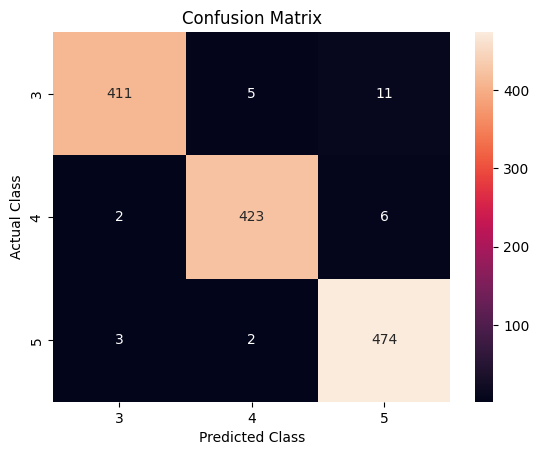

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
y_pred = cuadricula.predict(X1_test)
cm = confusion_matrix(y1_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', xticklabels=encoder.classes_, yticklabels=encoder.classes_)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')


plt.show()